In [3]:
from typing import Tuple, Sequence, Dict, Union, Optional, Callable
import zarr
import collections


import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from torchvision.ops import FeaturePyramidNetwork
from utils.clip import load_clip
import einops
import torch.nn as nn
import torch.nn.functional as F
from utils.layers import RelativeCrossAttentionModule
from models.conditional_unet1d import ConditionalUnet1D
from utils.position_encodings import SinusoidalPosEmb
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from utils.position_encodings import RotaryPositionEncoding, RotaryPositionEncoding3D, RotaryPositionEncoding2D
from tqdm.auto import tqdm
import copy
import matplotlib.pyplot as plt

# env import
import gym
from gym import spaces
import pygame
import pymunk
import pymunk.pygame_util
from pymunk.space_debug_draw_options import SpaceDebugColor
from pymunk.vec2d import Vec2d
import shapely.geometry as sg
import cv2
import skimage.transform as st
from skvideo.io import vwrite
from IPython.display import Video
import gdown
import os

from utils.environment import PushTImageEnv
from utils.dataset import PushTImageDataset, unnormalize_data, normalize_data

In [2]:
# 0. create env object
env = PushTImageEnv()

# 1. seed env for initial state.
# Seed 0-200 are used for the demonstration dataset.
env.seed(1000)

# 2. must reset before use
obs, info = env.reset()

# 3. 2D positional action space [0,512]
action = env.action_space.sample()

# 4. Standard gym step method
obs, reward, terminated, truncated, info = env.step(action)

# prints and explains each dimension of the observation and action vectors
with np.printoptions(precision=4, suppress=True, threshold=5):
    print("obs['image'].shape:", obs['image'].shape, "float32, [0,1]")
    print("obs['agent_pos'].shape:", obs['agent_pos'].shape, "float32, [0,512]")
    print("obs['goal_pose'].shape:", obs['goal_pose'].shape, "float32, [0,512]")
    print("action.shape: ", action.shape, "float32, [0,512]")
    print("obs['tee_mask'].shape:", obs['tee_mask'].shape, "uint8, {0,1}")
    print("obs['goal_mask'].shape:", obs['goal_mask'].shape, "uint8, {0,1}")
    print("obs['agent_mask'].shape:", obs['agent_mask'].shape, "uint8, {0,1}")

obs['image'].shape: (3, 96, 96) float32, [0,1]
obs['agent_pos'].shape: (2,) float32, [0,512]
obs['goal_pose'].shape: (3,) float32, [0,512]
action.shape:  (2,) float32, [0,512]
obs['tee_mask'].shape: (96, 96) uint8, {0,1}
obs['goal_mask'].shape: (96, 96) uint8, {0,1}
obs['agent_mask'].shape: (96, 96) uint8, {0,1}


In [4]:
#@markdown ### **Dataset Demo**

# download demonstration data from Google Drive
dataset_path = "../data/pusht_cchi_v7_replay.zarr.zip"
if not os.path.isfile(dataset_path):
    id = "1KY1InLurpMvJDRb14L9NlXT_fEsCvVUq&confirm=t"
    gdown.download(id=id, output=dataset_path, quiet=False)

# parameters
pred_horizon = 16
obs_horizon = 2
action_horizon = 8
#|o|o|                             observations: 2
#| |a|a|a|a|a|a|a|a|               actions executed: 8
#|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

# create dataset from file
dataset = PushTImageDataset(
    dataset_path=dataset_path,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon
)
# save training data statistics (min, max) for each dim
stats = dataset.stats

# create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    num_workers=4,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=True
)

# visualize data in batch
batch = next(iter(dataloader))
print("batch['image'].shape:", batch['image'].shape)
print("batch['agent_pos'].shape:", batch['agent_pos'].shape)
print("batch['action'].shape", batch['action'].shape)

batch['image'].shape: torch.Size([64, 2, 3, 96, 96])
batch['agent_pos'].shape: torch.Size([64, 2, 2])
batch['action'].shape torch.Size([64, 16, 2])


In [5]:
overfit_batch = next(iter(dataloader))
overfit_batch = {k: torch.stack([v[0] for i in range(v.shape[0])]) for k, v in overfit_batch.items()}
overfit_batch['image'] = overfit_batch['image']
print("overfit_batch['image'].shape:", overfit_batch['image'].shape)
print("overfit_batch['agent_pos'].shape:", overfit_batch['agent_pos'].shape)
print("overfit_batch['action'].shape", overfit_batch['action'].shape)

print("overfit_batch['image'].max():", overfit_batch['image'].max())
print("overfit_batch['image'].min():", overfit_batch['image'].min())
print("overfit_batch['agent_pos'].max():", overfit_batch['agent_pos'].max())
print("overfit_batch['agent_pos'].min():", overfit_batch['agent_pos'].min())
print("overfit_batch['action'].max():", overfit_batch['action'].max())
print("overfit_batch['action'].min():", overfit_batch['action'].min())

overfit_batch['image'].shape: torch.Size([64, 2, 3, 96, 96])
overfit_batch['agent_pos'].shape: torch.Size([64, 2, 2])
overfit_batch['action'].shape torch.Size([64, 16, 2])
overfit_batch['image'].max(): tensor(1.)
overfit_batch['image'].min(): tensor(-0.4902)
overfit_batch['agent_pos'].max(): tensor(-0.3731)
overfit_batch['agent_pos'].min(): tensor(-0.6173)
overfit_batch['action'].max(): tensor(-0.3945)
overfit_batch['action'].min(): tensor(-0.6445)


In [10]:
from models.ema_model import EMAModel
from diffusers.optimization import get_scheduler
from policy.diffusion_transformer_image import DiffusionTransformerImage

num_epochs = 10
embedding_dim = 60
action_dim = 2
device = torch.device('cuda')
num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)
obs_horizon = 2
model = DiffusionTransformerImage(action_dim=action_dim,
                                obs_horizon=obs_horizon,
                                pred_horizon=pred_horizon,
                                noise_scheduler=noise_scheduler,
                                vis_backbone='clip',
                                re_cross_attn_layer_within=5,
                                re_cross_attn_num_heads_within=5,
                                re_cross_attn_layer_across=5,
                                re_cross_attn_num_heads_across=5,
                                kernel_size=5,
                                cond_predict_scale=True,
                                embedding_dim=embedding_dim,
                                device='cuda')
model = model.to(device)

ema_model = copy.deepcopy(model)
_ = model.to(device)
_ = ema_model.to(device)
ema = EMAModel(ema_model)


optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=1e-4, weight_decay=1e-6)

lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(dataloader) * num_epochs
)


with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    losses = list()
    for epoch_idx in tglobal:
        epoch_loss = list()
        # batch loop
        with tqdm(dataloader, desc='Batch', leave=False) as tepoch:
            for item in tepoch:
                item = overfit_batch
                loss = model.compute_loss(item)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # step lr scheduler every batch
                # this is different from standard pytorch behavior
                lr_scheduler.step()

                # update Exponential Moving Average of the model weights
                ema.step(model)

                # logging
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)
        epoch_loss = np.mean(epoch_loss)
        losses.append(epoch_loss)
        tglobal.set_postfix(loss=epoch_loss)

ema_model = ema.averaged_model

Epoch:  50%|█████     | 5/10 [04:43<04:42, 56.45s/it, loss=0.0011] 

pred - action:  [[ 40.789482   22.408432 ]
 [ 35.499786   -1.7770691]
 [-64.473854  -43.9287   ]
 [ 19.237587   40.30545  ]
 [-71.37442    47.00435  ]
 [ 21.955109   49.44185  ]
 [-71.58504   -43.837585 ]
 [-74.56192   -37.652893 ]
 [-38.69196    53.56685  ]
 [-74.390656    6.1463165]
 [ -9.455704   58.06685  ]
 [-23.09085   -18.34235  ]
 [-67.81676    -8.553989 ]
 [-73.06192    39.379463 ]
 [-72.87442    -2.5041275]
 [-72.68692    59.578964 ]]
pred - action:  1364.0415


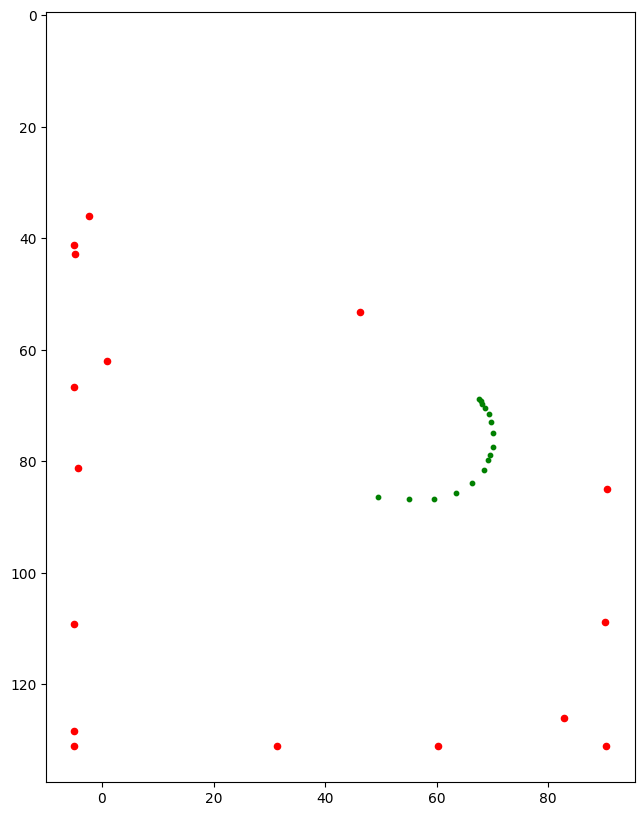

In [8]:
model.eval()
ema_model = ema.averaged_model
ema_model.eval()
with torch.no_grad():
    pred = ema_model.predict_action(overfit_batch)
    loss = ema_model.compute_loss(overfit_batch)
    pred = pred.cpu().numpy()
    action = overfit_batch['action'].cpu().numpy()
    agent_pos = overfit_batch['agent_pos'].cpu().numpy()


img = overfit_batch['image'][0,-1].numpy().transpose(1,2,0) 
pred = unnormalize_data(pred[0], stats['action']) / 512 * 96
action = unnormalize_data(action[0], stats['action']) / 512 * 96
print("pred - action: ", pred - action)
print("pred - action: ", np.abs(pred - action).sum())

plt.figure(figsize=(10, 10))
plt.imshow(img * 255)
plt.scatter(pred[:,0], pred[:,1], c='r', s=20, label='prediction')
plt.scatter(action[:,0], action[:,1], c='g', s=10, label='gt')
plt.show()

In [8]:
load_pretrained = True
if load_pretrained:
  import wandb
  id = "k3get0hm"
  file_dir = os.path.join("wandb", id)
  os.makedirs(file_dir, exist_ok=True)
  ckptn = wandb.restore('best_model.ckpt', 'felix-herrmann/T-Push/k3get0hm', root=file_dir).name
  ckpt = torch.load(ckptn)
  start_epoch = ckpt['epoch_idx'] + 1
  model.load_state_dict(ckpt['model'])
  model = model.to(device)
  best_loss = ckpt['loss']
  ema_model.load_state_dict(ckpt['ema_model'])
  ema_model = ema_model.to(device)
  optimizer.load_state_dict(ckpt['optimizer'])
  lr_scheduler.load_state_dict(ckpt['lr_scheduler'])
  print('Pretrained weights loaded.')
else:
  print("Skipped pretrained weight loading.")

Pretrained weights loaded.


In [10]:
if not load_pretrained:
    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.show()

In [9]:
# limit enviornment interaction to 200 steps before termination
max_steps = 200
env = PushTImageEnv()
# use a seed >200 to avoid initial states seen in the training dataset
env.seed(10000)

# get first observation
obs, info = env.reset()

# keep a queue of last 2 steps of observations
obs_deque = collections.deque(
    [obs] * obs_horizon, maxlen=obs_horizon)
# save visualization and rewards
imgs = [env.render(mode='rgb_array')]
rewards = list()
done = False
step_idx = 0

with tqdm(total=max_steps, desc="Eval PushTImageEnv") as pbar:
    while not done:
        B = 1
        images = np.stack([x['image'] for x in obs_deque])
        agent_poses = np.stack([x['agent_pos'] for x in obs_deque])

        # normalize observation
        nagent_poses = normalize_data(agent_poses, stats=stats['agent_pos'])
        # images are already normalized to [0,1]
        # nimages = (images * 2 - 1).astype(np.float32)
        nimages = images.astype(np.float32)

        # device transfer
        nimages = torch.from_numpy(nimages).to(device, dtype=torch.float32).unsqueeze(0)
        # (1,2,3,96,96)
        nagent_poses = torch.from_numpy(nagent_poses).to(device, dtype=torch.float32).unsqueeze(0)
        # (1,2,2)
        
        obs_dict = {
            'image': nimages,
            'agent_pos': nagent_poses
        }

        # predict action
        with torch.no_grad():
            naction = ema_model.predict_action(obs_dict)
            naction = naction.cpu().numpy()[0]
        
        action_pred = unnormalize_data(naction, stats['action'])

        # only take action_horizon number of actions
        start = obs_horizon - 1
        end = start + action_horizon
        action = action_pred[start:end,:]
        # (action_horizon, action_dim)

        for i in range(len(action)):
            # stepping env
            obs, reward, done, _, info = env.step(action[i])
            # save observations
            obs_deque.append(obs)
            # and reward/vis
            rewards.append(reward)
            imgs.append(env.render(mode='rgb_array'))

            # update progress bar
            step_idx += 1
            pbar.update(1)
            pbar.set_postfix(reward=reward)
            if step_idx > max_steps:
                done = True
            if done:
                break

# print out the maximum target coverage
print('Score: ', max(rewards))

# visualize
from IPython.display import Video
vwrite('vis.mp4', imgs)
Video('vis.mp4', embed=True, width=256, height=256)

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv: 201it [00:33,  5.97it/s, reward=0]                         

Score:  0.0
